In [1]:
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
sys.path.append('../../src')
from Library import VerboseLibrary
from ActivityClassifier import PatientTrendAwareThresholder
import matplotlib.colors as mcolors

named_colors = list(mcolors.TABLEAU_COLORS) * 3

device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Models

In [2]:
model_names = sorted(os.listdir('./models_PTAT'))
len(model_names)

10

In [3]:
model_coefficient_history = {}
model_coefficient_mask = {}
model_coefficients = {}

for name in tqdm(model_names):
    model = torch.load(os.path.join('.', 'models_PTAT', name)).to(device)
    model_coefficient_history[name] = np.array(model.coefficient_history)
    model_coefficients[name] = np.array(model.coefficient_mask.detach().cpu().numpy() * model.coefficients.detach().cpu().numpy())
    model_coefficient_mask[name] = np.array(model.coefficient_mask)

100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


In [4]:
model_linear_detected = {name: np.array([model_coefficient_mask[name][1:3, j].any() for j in range(2)]) for name in model_names}
model_any_detected = {name: np.array([model_coefficient_mask[name][[k for k in range(12) if k not in [1, 2]], j].any() and not model_linear_detected[name][j] for j in range(2)]) for name in model_names}
model_none_detected = {name: np.array([not model_linear_detected[name][j] and not model_linear_detected[name][j] for j in range(2)]) for name in model_names}

# Coefficients

In [5]:
masked_coefficient_list = np.array([model_coefficients[name]for name in model_names])
masked_coefficient_list_str = np.array([model_coefficients[name].round(2) for name in model_names], dtype=object)

In [6]:
masked_coefficient_list_str[np.abs(masked_coefficient_list) < 0.005] = '<0.005'
masked_coefficient_list_str[masked_coefficient_list == 0] = '-'

In [7]:
pd.DataFrame(masked_coefficient_list_str[:, :, 0], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1 z_1   z_2 z_1*z_1 z_1*z_2 z_2*z_2 z_1*z_1*z_1 z_1*z_1*z_2 z_1*z_2*z_2  \
0  -   - -0.93       -       -       -           -           -           -   
1  -   - -0.91       -       -       -           -           -           -   
2  -   -  0.91       -       -       -           -           -           -   
3  -   - -0.84       -       -       -           -           -           -   
4  -   -  0.93       -       -       -           -           -           -   
5  -   -  0.88       -       -       -           -           -           -   
6  -   -  0.93       -       -       -           -           -           -   
7  -   - -0.93       -       -       -           -           -           -   
8  -   - -1.07       -       -       -           -           -           -   
9  -   - -1.14       -       -       -           -           -           -   

  z_2*z_2*z_2 sin(z_1) sin(z_2)  
0           -        -        -  
1           -        -        -  
2           -        -        -  
3           -        -        -  
4           -        -        -  
5           -        -        -  
6           -        -        -  
7           -        -        -  
8           -        -        -  
9           -        -        -

In [8]:
pd.DataFrame(masked_coefficient_list_str[:, :, 1], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1   z_1 z_2 z_1*z_1 z_1*z_2 z_2*z_2 z_1*z_1*z_1 z_1*z_1*z_2 z_1*z_2*z_2  \
0  -  0.89   -       -       -       -           -           -           -   
1  -  0.91   -       -       -       -           -           -           -   
2  - -0.91   -       -       -       -           -           -           -   
3  -  0.99   -       -       -       -           -           -           -   
4  - -0.89   -       -       -       -           -           -           -   
5  - -0.94   -       -       -       -           -           -           -   
6  - -0.89   -       -       -       -           -           -           -   
7  -  0.89   -       -       -       -           -           -           -   
8  -  0.77   -       -       -       -           -           -           -   
9  -  0.73   -       -       -       -           -           -           -   

  z_2*z_2*z_2 sin(z_1) sin(z_2)  
0           -        -        -  
1           -        -        -  
2           -        -        -  
3           -        -        -  
4           -        -        -  
5           -        -        -  
6           -        -        -  
7           -        -        -  
8           -        -        -  
9           -        -        -

In [9]:
m = model_names[-3]
xlim = 6000
split_size = 3

fig, ax = plt.subplots(2, 4, figsize=(30, 10))
fig.tight_layout(w_pad=6, h_pad=5)

for split in range(4):
    for j in range(2):
        for i, (n, c) in enumerate(
            zip(VerboseLibrary(model.library).build_verbose()[split*split_size:(split+1)*split_size],
            model_coefficient_history[m][:, :, j].T[split*split_size:(split+1)*split_size],
            )):
            ax[j][split].plot(c[:xlim].T, label=n, color=named_colors[i%len(named_colors)])
            ax[j][split].legend(); ax[j][split].axhspan(-0.1, 0.1, color='black', alpha=0.01); ax[j][split].set_xlim(0, xlim); ax[j][split].set_ylim(-1.1, 1.1)

# Only Sin Curves

In [10]:
model_coefficient_history[name].shape

(12000, 12, 2)

100%|██████████| 10/10 [00:00<00:00, 53.31it/s]


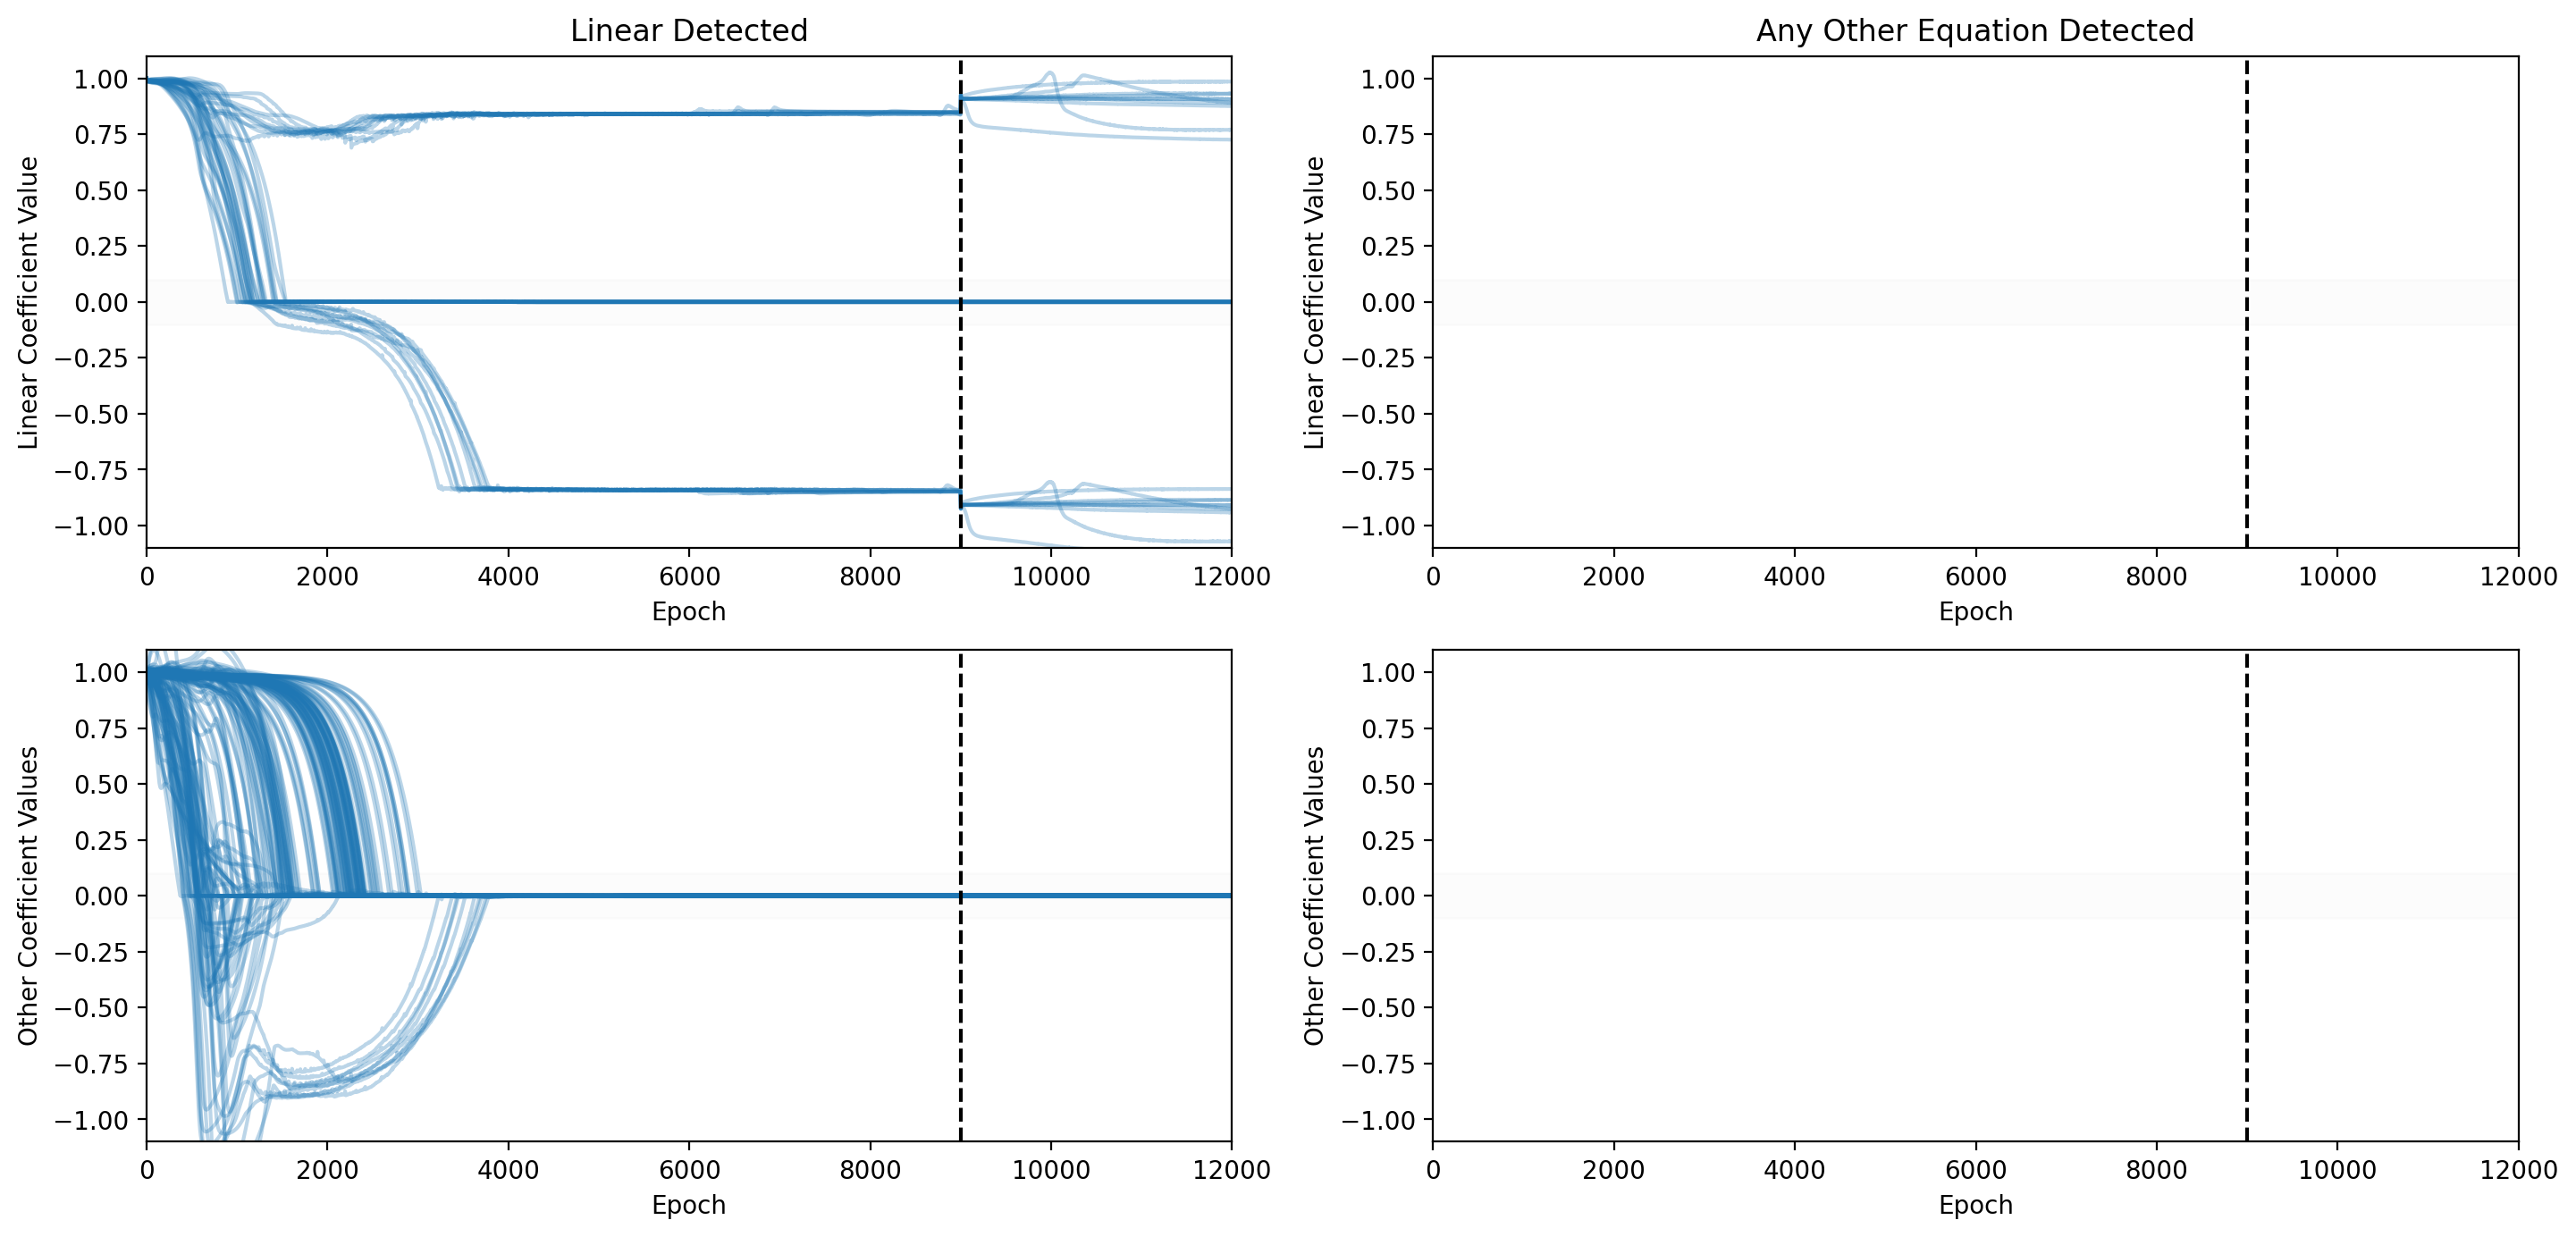

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(21/1.5, 10/1.5), dpi=200)
fig.tight_layout(w_pad=5, h_pad=2)
xlim = 12000

alpha = 0.3

for name in tqdm(model_names):
    for i in range(2):
        if model_linear_detected[name][i]:
            axes[0][0].plot(model_coefficient_history[name][:xlim, 1:3, i], color='tab:blue', alpha=alpha);
            axes[1][0].plot(model_coefficient_history[name][:xlim, 0, i], color='tab:blue', alpha=alpha);
            axes[1][0].plot(model_coefficient_history[name][:xlim, 3:, i], color='tab:blue', alpha=alpha);
        if model_any_detected[name][i]:
            axes[0][1].plot(model_coefficient_history[name][:xlim, 1:3, i], color='tab:orange', alpha=alpha);
            axes[1][1].plot(model_coefficient_history[name][:xlim, 0, i], color='tab:orange', alpha=alpha);
            axes[1][1].plot(model_coefficient_history[name][:xlim, 3:, i], color='tab:orange', alpha=alpha);

axes[0][0].set_title(f'Linear Detected');
axes[0][1].set_title(f'Any Other Equation Detected');

for ax in axes[0]:
    ax.set_xlabel('Epoch'); ax.set_ylabel('Linear Coefficient Value'); ax.set_xlim(0, xlim); ax.set_ylim(-1.1, 1.1)
    ax.axhspan(-0.1, 0.1, color='black', alpha=0.01);ax.axvline(9000, color='black', linestyle='--')

for ax in axes[1]:
    ax.set_xlabel('Epoch'); ax.set_ylabel('Other Coefficient Values'); ax.set_xlim(0, xlim); ax.set_ylim(-1.1, 1.1)
    ax.axhspan(-0.1, 0.1, color='black', alpha=0.01); ax.axvline(9000, color='black', linestyle='--')

# Thresholding

In [7]:
def trend(a, lengthscale=5):
    mean_diff_last_values, var_last_values = np.mean(a[-2*lengthscale:-lengthscale], axis=0), np.var(a[-2*lengthscale:-lengthscale], axis=0)
    mean_diff_now_values, var_now_values = np.mean(a[-lengthscale:], axis=0), np.var(a[-lengthscale:], axis=0)
    return mean_diff_now_values - mean_diff_last_values, np.sqrt(var_last_values + var_now_values)

In [8]:
def trend_speed(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        return trend(a, lengthscale)[0]
    return np.zeros(a.shape[1:])

In [9]:
def trend_significance(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        t = trend(a, lengthscale)
        r = np.copy(t[0])
        r[(t[0] != 0) & (t[1] == 0)] = np.nan
        r[(t[0] != 0) & (t[1] != 0)] = t[0][(t[0] != 0) & (t[1] != 0)] / t[1][(t[0] != 0) & (t[1] != 0)]
        return r
    return np.zeros(a.shape[1:])

In [10]:
model_trend_significances = {}
model_trend_speed = {}
for name in tqdm(model_names):
    model_trend_significances[name] = np.stack([trend_significance(model_coefficient_history[name][:i]) for i in range(12000)])
    model_trend_speed[name] = np.stack([trend_speed(model_coefficient_history[name][:i]) for i in range(12000)])

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


In [11]:
model_classified_history = {}
model_classified_plus_history = {}

for name in tqdm(model_names):
    ptat = PatientTrendAwareThresholder(patience=3000)
    model_classified_history[name] = np.stack([ptat.classify_converged(model_coefficient_history[name][:i])[0] for i in range(1, len(model_coefficient_history[name]))])

100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


In [12]:
model_coefficient_activity_history = {name: (model_coefficient_history[name][1:] - model_coefficient_history[name][:-1]).astype(bool) for name in model_names}
model_thresholded_epochs = {name: np.where((~model_coefficient_activity_history[name][1:] & model_coefficient_activity_history[name][:-1])) for name in model_names}
model_before_thresholded_epochs = {name: (model_thresholded_epochs[name][0] - 5, model_thresholded_epochs[name][1], model_thresholded_epochs[name][2]) for name in model_names}

model_before_thresholded_epochs[model_names[2]]

(array([   88,    94,   110,   150,   212,   217,  3739,  3806,  3810,
         3865,  3897,  3977,  3999,  4112,  4187,  4542,  4593,  4613,
         4631,  4638,  4855,  4861,  5132,  5138,  5432,  5449,  6946,
         6979,  7611, 11171]),
 array([ 4,  8,  9,  9,  7,  8,  3,  3,  0, 10,  1,  4, 11,  4,  2,  0,  5,
         6,  6,  5,  7,  7,  8,  8,  9,  9, 10, 11,  2,  1]),
 array([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1]))

In [13]:
model_thresholded_trend_speed_values = {name: model_trend_speed[name][model_before_thresholded_epochs[name]] for name in model_names}
model_thresholded_trend_significance_values = {name: model_trend_significances[name][model_thresholded_epochs[name]] for name in model_names}
model_thresholded_coefficient_values = {name: model_coefficient_history[name][model_thresholded_epochs[name]] for name in model_names}

In [14]:
all_models_thresholded_coefficient_values = []
all_models_thresholded_trend_significance_values = []
all_models_thresholded_trend_speed_values = []

for name in model_names:
    all_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
    all_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
    all_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])

In [15]:
reasonable_cutoff = 0.2/5 # coefficient may change by double the ST-Zone in 5000 epochs
unreasonable_cutoff = 0.2/0.1 # coefficient may change by double the ST-Zone in 100 epochs

In [16]:
ptat_used_trend_threshold = 0.002 # per epoch

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6.5/1.8, 6/1.8), dpi=200)
fig.tight_layout(w_pad=5)

# dm in 5 Epochs 
# 200 * dm in 1000 Epochs
ax.scatter(np.abs(all_models_thresholded_trend_significance_values), np.abs(all_models_thresholded_trend_speed_values) * 200, color='black', marker='^', s=10, zorder=3);
ax.set_ylabel(r'Rate of Change  $\left[\frac{\Delta \xi}{1000 \,\,\mathrm{Epochs}}\right]$'); ax.set_xlabel(r'Significance $[\sigma]$'); ax.set_yscale('log'); ax.grid(alpha=0.3, zorder=1);
ax.axhspan(1e-6, reasonable_cutoff, color='tab:green', alpha=0.2);
ax.axhspan(reasonable_cutoff, unreasonable_cutoff, color='tab:orange', alpha=0.2);
ax.axhspan(unreasonable_cutoff, 100, color='tab:red', alpha=0.2);
ax.axhline(unreasonable_cutoff, color='tab:red')
ax.axhline(reasonable_cutoff, color='tab:green')
# ax.axhline(1e3*ptat_used_trend_threshold, color='black', alpha=0.5, linestyle='--', label=r'$b = 0.002$')
ax.set_ylim(1e-5, 15), ax.set_xlim(-0.1, 3.1); 
# ax.legend();